In [4]:
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import mode, entropy
from scipy.linalg import svd

## Attempt 1: Simple

In [3]:
data_directory = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/EDA Analysis Input Files'
combined_df = pd.DataFrame()

for file in os.listdir(data_directory):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_directory, file)
        temp = pd.read_excel(file_path, sheet_name='Sheet3')
        parts = file.replace('.xlsx', '').split('_')
        if len(parts) >= 3 and parts[-1] == "new":
            patient_id = f"{parts[-3]}_{parts[-2]}"
        else:
            patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        combined_df = pd.concat([combined_df, temp], ignore_index=True)

In [4]:
combined_df['Sleep_stage'] = combined_df['Sleep_stage'].astype(str)
combined_df['Sleep_stage'] = combined_df['Sleep_stage'].replace('3', '2')
combined_df['Sleep_stage'] = combined_df['Sleep_stage'].replace('r', 'R')

In [5]:
print(combined_df.head())  
print(f"Total records combined: {len(combined_df)}")

   Onset_EEG Sleep_stage            Date_EEG  EDR_count      Date_E4_synced  \
0   26759.25           1 2017-07-14 22:47:39          0 2017-07-14 22:46:10   
1   26788.25           W 2017-07-14 22:48:08          0 2017-07-14 22:46:39   
2   26818.25           W 2017-07-14 22:48:38          0 2017-07-14 22:47:09   
3   26848.25           W 2017-07-14 22:49:08          0 2017-07-14 22:47:39   
4   26878.25           W 2017-07-14 22:49:38          0 2017-07-14 22:48:09   

   Storm_mark  Epoch duration  Epoch duration (rounded)  \
0           0       29.000004                      29.0   
1           0       29.999998                      30.0   
2           0       29.999998                      30.0   
3           0       29.999998                      30.0   
4           0       29.000004                      29.0   

   Average EDA per epoch Patient_ID  
0               0.114790     P31_LW  
1               0.109703     P31_LW  
2               0.106686     P31_LW  
3               0.

In [6]:
combined_df.isnull().sum()

Onset_EEG                     0
Sleep_stage                   0
Date_EEG                      0
EDR_count                     0
Date_E4_synced                0
Storm_mark                    0
Epoch duration               49
Epoch duration (rounded)     49
Average EDA per epoch       423
Patient_ID                    0
dtype: int64

In [7]:
combined_df = combined_df.dropna()

In [8]:
X = combined_df.drop(['Sleep_stage', 'Onset_EEG', 'Date_EEG', 'Patient_ID'], axis=1)
X['Date_E4_synced_hour'] = X['Date_E4_synced'].dt.hour
X = X.drop(['Date_E4_synced'], axis=1)
print(X)

y = combined_df['Sleep_stage']

       EDR_count  Storm_mark  Epoch duration  Epoch duration (rounded)  \
0              0           0       29.000004                      29.0   
1              0           0       29.999998                      30.0   
2              0           0       29.999998                      30.0   
3              0           0       29.999998                      30.0   
4              0           0       29.000004                      29.0   
...          ...         ...             ...                       ...   
46122          0           0       29.000004                      29.0   
46123          0           0       29.999998                      30.0   
46124          0           0       29.999998                      30.0   
46125          0           0       29.999998                      30.0   
46126          0           0       29.000004                      29.0   

       Average EDA per epoch  Date_E4_synced_hour  
0                   0.114790                   22  
1      

In [9]:
X.isnull().sum()

EDR_count                   0
Storm_mark                  0
Epoch duration              0
Epoch duration (rounded)    0
Average EDA per epoch       0
Date_E4_synced_hour         0
dtype: int64

In [10]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.59      0.59      5045
           2       0.52      0.50      0.51      5034
           R       0.58      0.59      0.58      4960
           W       0.56      0.58      0.57      4912

    accuracy                           0.56     19951
   macro avg       0.56      0.56      0.56     19951
weighted avg       0.56      0.56      0.56     19951



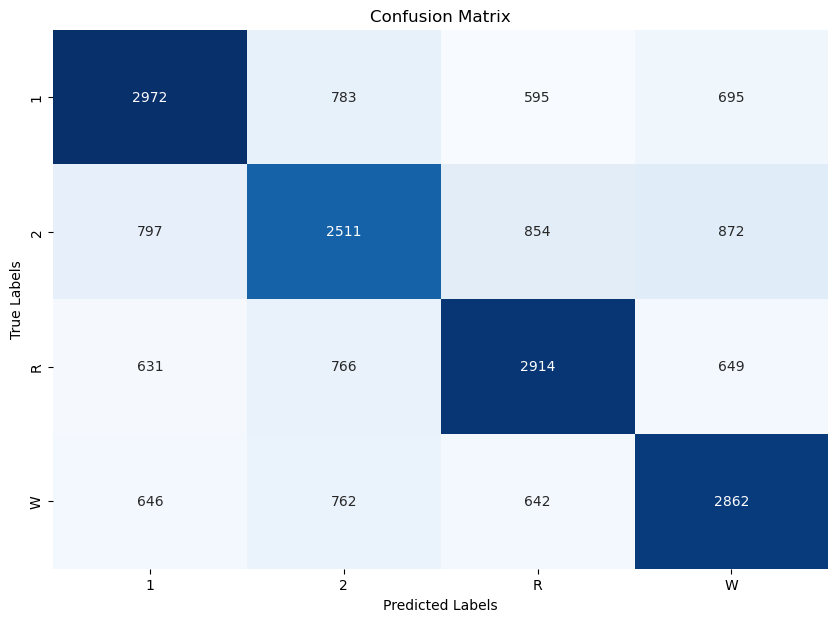

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['1', '2', 'R', 'W'],  
            yticklabels=['1', '2', 'R', 'W'],
            cbar=False)  # Disable color bar

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Attempt 2: Optimize Hyperparameters

In [15]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples per split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Sampling technique
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [16]:
# Use the best model found by GridSearchCV
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.59      0.60      5045
           2       0.57      0.53      0.55      5034
           R       0.57      0.65      0.61      4960
           W       0.60      0.59      0.59      4912

    accuracy                           0.59     19951
   macro avg       0.59      0.59      0.59     19951
weighted avg       0.59      0.59      0.59     19951



## Attempt 3: Added features

In [9]:
cleaned_eda_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Cleaned EDA input files"
output_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features"
patient_info_file = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/Data.csv'

os.makedirs(output_folder, exist_ok=True)

df_patient_info = pd.read_csv(patient_info_file)  
df_patient_info.set_index("Record ID", inplace=True)

def extract_features(signal):
    if len(signal) == 0:
        return {key: np.nan for key in ["Mode", "Median", "MaxAbs", "LineLength", "10thQuantile", "75thQuantile", "NonLinearEnergy", "SVD_Entropy", "ShannonEntropy"]}

    mode_result = mode(signal, nan_policy="omit")
    mode_value = mode_result.mode.item() if mode_result.mode.size > 0 else np.nan
    
    features = {
        "Mode": mode_value,
        "Median": np.median(signal),
        "MaxAbs": np.max(np.abs(signal)),
        "LineLength": np.sum(np.abs(np.diff(signal))),
        "10thQuantile": np.quantile(signal, 0.10),
        "75thQuantile": np.quantile(signal, 0.75),
        "NonLinearEnergy": np.sum(signal[:-2] * signal[1:-1] - signal[2:] ** 2) if len(signal) > 2 else np.nan,
    }

    # Singular Value Decomposition (SVD) Entropy
    if len(signal) > 1:
        U, S, V = np.linalg.svd(np.reshape(signal, (-1, 1)), full_matrices=False)
        if np.sum(S) > 0:  # Avoid division by zero
            S_norm = S / np.sum(S)
            features["SVD_Entropy"] = -np.sum(S_norm * np.log2(S_norm + 1e-10))
        else:
            features["SVD_Entropy"] = np.nan
    else:
        features["SVD_Entropy"] = np.nan

    # Shannon Entropy
    hist, _ = np.histogram(signal, bins=10, density=True)
    hist = hist + 1e-10  # Prevent log(0)
    features["ShannonEntropy"] = entropy(hist, base=2)

    return features

def find_matching_eda_file(patient_id):
    core_id = re.sub(r"(_new|\d+)$", "", patient_id) 
    matching_files = glob.glob(os.path.join(cleaned_eda_folder, f"EDA_{core_id}*.csv"))
    return matching_files[0] if matching_files else None

def extract_numeric_id(patient_id):
    """Extract the numeric part from a patient ID like 'P36_LW' -> '36'"""
    match = re.search(r"P?(\d+)", patient_id)
    return match.group(1) if match else None

# Process all patients
for file in os.listdir(data_directory):
    if file.startswith("EDA_Analysis_") and file.endswith(".xlsx"):
        patient_id = file.replace("EDA_Analysis_", "").replace(".xlsx", "")
        numeric_id = extract_numeric_id(patient_id)
        if not numeric_id:
            print(f"Could not extract numeric ID from {patient_id}, skipping...")
            continue
        excel_path = os.path.join(data_directory, file)

        csv_path = find_matching_eda_file(patient_id)

        if not csv_path:
            print(f"Missing EDA file for {patient_id}, skipping...")
            continue

        print(f"Processing {patient_id}...")

        # Load epoch durations from Excel
        df_excel = pd.read_excel(excel_path, sheet_name="Sheet3")
        epoch_durations = df_excel["Epoch duration (rounded)"].dropna().values
        
        extra_features = df_excel[["Average EDA per epoch", "EDR_count", "Storm_mark", "Sleep_stage"]].dropna()

        # Load EDA signal data
        df_eda = pd.read_csv(csv_path)
        df_eda.columns = ["EDA"]
        eda_signal = df_eda["EDA"].values
        feature_list = []

        # Segment EDA signal based on epoch durations
        start_idx = 0
        for i, duration in enumerate(epoch_durations):
            end_idx = start_idx + int(duration)  # Convert duration to sample index

            if end_idx > len(eda_signal):  
                break  # Stop if we run out of data

            epoch_signal = eda_signal[start_idx:end_idx]
            features = extract_features(epoch_signal)

            if i < len(extra_features):
                features.update(extra_features.iloc[i].to_dict())
                
            feature_list.append(features)  # Do NOT include Patient_ID

            start_idx = end_idx  # Move to next epoch

        # Save extracted features
        if feature_list:
            feature_df = pd.DataFrame(feature_list)
            try:
                numeric_id_int = int(numeric_id)
                if numeric_id_int in df_patient_info.index:
                    print(f"Found patient info for ID {numeric_id_int}. Adding age/gender.")
                    feature_df["Age"] = df_patient_info.loc[numeric_id_int, "Age (Years)"]
                    feature_df["Gender"] = df_patient_info.loc[numeric_id_int, "Gender"]
                else:
                    print(f"Missing patient info for ID {numeric_id_int}, skipping age/gender.")
            except ValueError:
                print(f"Invalid numeric ID: {numeric_id}, skipping age/gender.")

            output_path = os.path.join(output_folder, f"Features_{patient_id}.csv")
            feature_df.to_csv(output_path, index=False)
            print(f"Saved features for {patient_id}")

print("Processing complete.")

NameError: name 'data_directory' is not defined

In [10]:
output_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features"
features_df = pd.DataFrame()

for file in os.listdir(output_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(output_folder, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

In [11]:
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')

In [12]:
print(features_df.head()) 
print(f"Total records combined: {len(features_df)}")

       Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0  0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1  0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2  0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3  0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4  0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   

   NonLinearEnergy   SVD_Entropy  ShannonEntropy  Average EDA per epoch  \
0         0.970088 -1.442695e-10        0.210842               0.259464   
1        -0.002847 -1.442695e-10        2.678204               0.262164   
2        -0.000259 -1.442695e-10        3.076895               0.263591   
3        -0.000548 -1.442695e-10        3.031402               0.264969   
4        -0.000012 -1.442695e-10        2.815061               0.265454   

   EDR_count  Storm_mark Sleep_stage  Age  Gender           Date_E4_synced  \
0        0.0        

In [13]:
features_df.isnull().sum()

Mode                        23
Median                      23
MaxAbs                      23
LineLength                  23
10thQuantile                23
75thQuantile                23
NonLinearEnergy             23
SVD_Entropy               1071
ShannonEntropy              23
Average EDA per epoch      374
EDR_count                  374
Storm_mark                   0
Sleep_stage                  0
Age                          0
Gender                       0
Date_E4_synced               0
time_since_storm_start       0
time_since_last_storm        0
Patient_ID                   0
dtype: int64

In [14]:
features_df = features_df.dropna()

In [17]:
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced'], axis=1)
print(X)

y = features_df['Sleep_stage']

           Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0      0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1      0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2      0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3      0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4      0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   
...         ...       ...       ...         ...           ...           ...   
46074  0.137735  0.138617  0.139257    0.001609      0.137823      0.139119   
46075  0.137768  0.137965  0.138593    0.001052      0.137860      0.138386   
46076  0.137561  0.137830  0.138889    0.002131      0.137613      0.138564   
46077  0.137962  0.138478  0.138784    0.001489      0.138241      0.138600   
46078  0.138364  0.138666  0.139057    0.001295      0.138420      0.138899   

       NonLinearEnergy   SVD_Entropy  ShannonEntrop

In [18]:
if "Gender" in X.columns:
    le = LabelEncoder()
    X["Gender"] = le.fit_transform(X["Gender"])  # Converts 'Female' -> 0, 'Male' -> 1

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples per split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Sampling technique
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [2]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

NameError: name 'grid_search' is not defined

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.84      0.83      4903
           2       0.83      0.82      0.83      4886
           R       0.87      0.90      0.89      4936
           W       0.88      0.84      0.86      4746

    accuracy                           0.85     19471
   macro avg       0.85      0.85      0.85     19471
weighted avg       0.85      0.85      0.85     19471



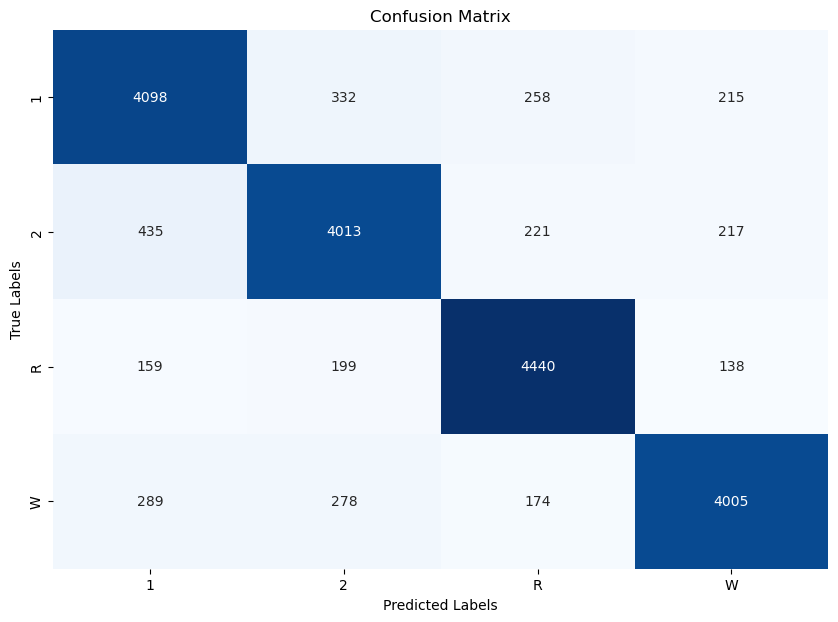

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['1', '2', 'R', 'W'],  
            yticklabels=['1', '2', 'R', 'W'],
            cbar=False)  # Disable color bar

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Removing Redundant Features with PCC

In [ ]:
# Select only numeric columns (excluding categorical and target variable)
numeric_features = features_df.select_dtypes(include=[np.number])

# Compute Pearson correlation matrix
corr_matrix = numeric_features.corr().abs()

# Define the correlation threshold
threshold = 0.85

# Find highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop redundant features from the original dataframe
features_df_reduced = features_df.drop(columns=to_drop)

print("Dropped Features:", to_drop)
print("Remaining Features:", features_df_reduced.columns.tolist())

# Save the cleaned features
cleaned_output_path = os.path.join(output_folder, "Cleaned_Features.csv")
features_df_reduced.to_csv(cleaned_output_path, index=False)
print(f"Saved cleaned features to {cleaned_output_path}")

Dropped Features: ['Median', 'MaxAbs', '10thQuantile', '75thQuantile']
Remaining Features: ['Mode', 'LineLength', 'NonLinearEnergy', 'SVD_Entropy', 'ShannonEntropy', 'Average EDA per epoch', 'EDR_count', 'Storm_mark', 'Sleep_stage', 'Age', 'Gender', 'Patient_ID']
Saved cleaned features to /Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features/Cleaned_Features.csv


In [ ]:
features_df_reduced.isnull().sum()

Mode                     0
LineLength               0
NonLinearEnergy          0
SVD_Entropy              0
ShannonEntropy           0
Average EDA per epoch    0
EDR_count                0
Storm_mark               0
Sleep_stage              0
Age                      0
Gender                   0
Patient_ID               0
dtype: int64

In [ ]:
X = features_df_reduced.drop(['Sleep_stage', 'Patient_ID'], axis=1)
y = features_df['Sleep_stage']

In [ ]:
if "Gender" in X.columns:
    le = LabelEncoder()
    X["Gender"] = le.fit_transform(X["Gender"])  # Converts 'Female' -> 0, 'Male' -> 1

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples per split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Sampling technique
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.34      0.13      0.19       628
           2       0.80      0.93      0.86      4935
           R       0.81      0.77      0.79      2013
           W       0.75      0.56      0.64      1351

    accuracy                           0.78      8927
   macro avg       0.67      0.60      0.62      8927
weighted avg       0.76      0.78      0.77      8927



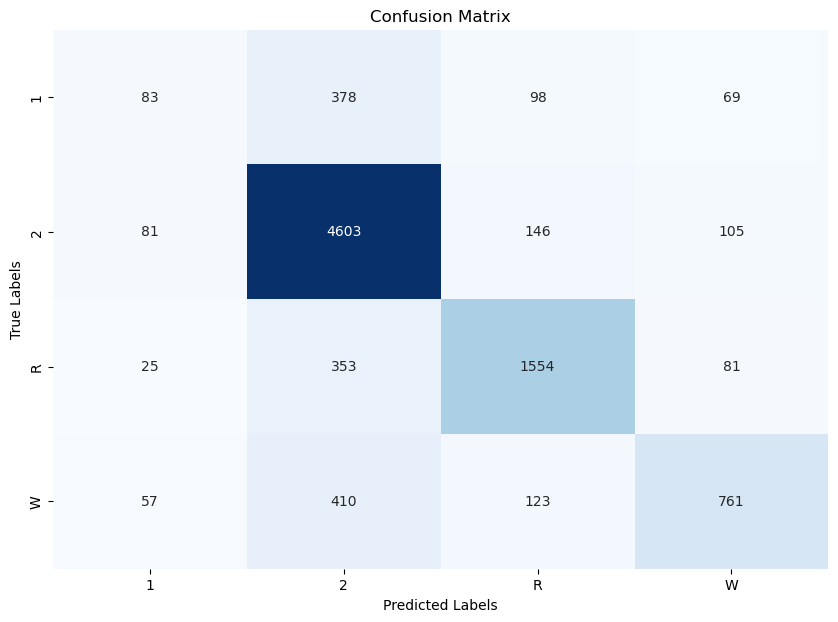

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['1', '2', 'R', 'W'],  
            yticklabels=['1', '2', 'R', 'W'],
            cbar=False)  # Disable color bar

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()